In [3]:
%matplotlib inline

import os
import pysrt # pip install pysrt
import ass # pip install ass
from collections import namedtuple

import numpy as np
from scipy.spatial.distance import cdist
import matplotlib
from matplotlib import pyplot as plt
matplotlib.style.use("ggplot")

/Users/dennybritz/venvs/tf/lib/python3.5/site-packages/ass/__init__.py:7: UserWarning: Could not load renderer: dlsym(RTLD_DEFAULT, ass_set_fonts_dir): symbol not found
  warnings.warn("Could not load renderer: " + str(e))


In [4]:
DATA_DIR_EN = "/Users/dennybritz/Downloads/daddicts_subs/en"
DATA_DIR_JA = "/Users/dennybritz/Downloads/daddicts_subs/ja"

In [5]:
def parse_sub(filename):
  # TRY ASS
  try:
    with open(filename) as f:
      subs = ass.parse(f)
      return ("ASS", subs)
  except: 
    pass

  # Try SRT
  try:
    subs = pysrt.open(filename, error_handling=2)
    return ("SRT", subs)
  except:
    pass

  return None      

In [6]:
def get_subs(directory):
  """Returns an iterator of (name, type) for all files in a directory.
  """
  for filename in os.listdir(directory):
    full_path = os.path.join(directory, filename)
    res = parse_sub(full_path)
    if res is not None:
      yield (full_path, res)

In [7]:
ja_subs_dict = dict(list(get_subs(DATA_DIR_JA)))
en_subs_dict = dict(list(get_subs(DATA_DIR_EN)))

In [8]:
print("Parsed {} Japanese subs".format(len(ja_subs_dict)))
print("Parsed {} English subs".format(len(en_subs_dict)))

Parsed 4401 Japanese subs
Parsed 12715 English subs


In [9]:
SubEvent = namedtuple("SubEvent", ["start_sec", "end_sec"])
def any_format_to_sub_events(format_and_subs):
  format_str, subs = format_and_subs
  events = []
  if format_str == "ASS":
    for ass_event in subs.events:
      e = SubEvent(ass_event.start.total_seconds(), ass_event.end.total_seconds())
      events.append(e)
  elif format_str == "SRT":
    for srt_event in subs:
      e = SubEvent(srt_event.start.ordinal/1000.0, srt_event.end.ordinal/1000.0)
      events.append(e)
  return events

In [10]:
# Convert all SRT/ASS subs to SubEvent instances
ja_events = { k: any_format_to_sub_events(v) for k, v in ja_subs_dict.items() }
en_events = { k: any_format_to_sub_events(v) for k, v in en_subs_dict.items() }

In [98]:
ja_events = { k: v for k, v in ja_events.items() if len(v) > 0 }
en_events = { k: v for k, v in en_events.items() if len(v) > 0 }

In [236]:
# Create vector representation
# The feature vector is 1 whenever someone is talking, 0 otherwise
# It "-1" before the first text appears, and -1 after the last text
# to discourage matching buggy subs that start after severa hours
def create_representation(sub_events, max_time=10000):
  """Creates a vector representation of the sub events"""
  res = np.zeros(max_time)
  for e in sub_events:
    if round(e.start_sec) < max_time:
      start_idx = round(e.start_sec)
      end_idx = round(e.end_sec)
      res[start_idx:end_idx] = 1.0
  
  # Set everything before first text to -1
  first_idx = round(sub_events[0].start_sec)
  res[:first_idx] = -1.0
  
  # Set everything after last text to -1
  last_idx = round(sub_events[-1].start_sec)
  res[last_idx:] = -1.0
  
  return res

In [237]:
# Create vector representations for EN and JA subs
ja_rep = { k: create_representation(v) for k,v in ja_events.items() }
en_rep = { k: create_representation(v) for k,v in en_events.items() }

In [238]:
# Unzip
en_reps_keys, en_reps_values = zip(*en_rep.items())
en_reps_matrix = np.array(en_reps_values)
ja_reps_keys, ja_reps_values = zip(*ja_rep.items())
ja_reps_matrix = np.array(ja_reps_values)

In [239]:
# Save, b/c computation takes long
np.save("/Users/dennybritz/Downloads/en_reps_matrix", en_reps_matrix)
np.save("/Users/dennybritz/Downloads/ja_reps_matrix", ja_reps_matrix)

(100, 12714)
0.0
/Users/dennybritz/Downloads/daddicts_subs/ja/file.php?id=64680
/Users/dennybritz/Downloads/daddicts_subs/en/file.php?id=64914


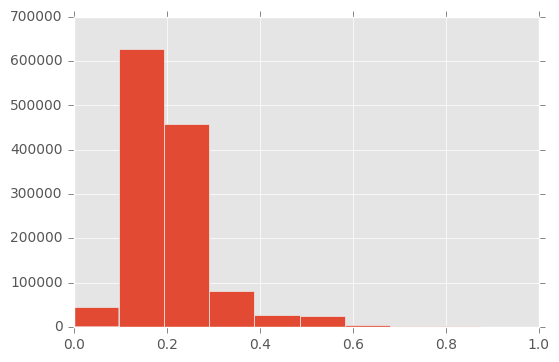

In [248]:
# Subset to make it faster for testing
ja_reps_matrix_ = ja_reps_matrix[0:100]

# TODO: Try different distance metrics?
sim = cdist(ja_reps_matrix_, en_reps_matrix, metric='hamming')
sim = np.nan_to_num(sim)

plt.hist(sim.flatten())
print(sim.shape)
match_idx = np.argmin(sim)
match_idx = np.unravel_index(match_idx, sim.shape)
print(sim[match_idx])

print(ja_reps_keys[match_idx[0]])
print(en_reps_keys[match_idx[1]])

In [249]:
# TODO: Tune this
THRESHOLD = 0.05
matches = []

for ja_idx, ja_sub in enumerate(sim):
  best_en_idx = np.argmin(sim[ja_idx])
  score = sim[ja_idx, best_en_idx]
  if score < THRESHOLD:
    matches.append((ja_reps_keys[ja_idx], en_reps_keys[best_en_idx], score))
#  print(best_score)

print(len(matches))  
matches[1]

54


('/Users/dennybritz/Downloads/daddicts_subs/ja/file.php?id=52914',
 '/Users/dennybritz/Downloads/daddicts_subs/en/file.php?id=46104',
 0.046399999999999997)